In [1]:
import tensorflow as tf

import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
dir_path = os.getcwd()

In [3]:
#load embendings

embeddings = np.loadtxt(os.path.join(dir_path,'cache','embeddings.vec'))

pickle_in = open('cache/database.dict', 'rb')
db = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open('cache/traindata.list', 'rb')
traindata = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open('cache/data2onehot.dict', 'rb')
dictionary = pickle.load(pickle_in)
pickle_in.close()

In [4]:
longest = np.argmax(list(map(lambda x : len(x),traindata)))

In [5]:
#longest sample
print(longest)
print(len(traindata[longest]))

1662
47701


In [6]:
# seperate data by length and by each label in one class 'Y_labels'
# and by jump instruction 'Y_if'
#
from JavaClassParser import ByteCode
reverse_dictionary = dict(zip(dictionary.values(),dictionary.keys()))
X_train=[]
Y_train=[]
X_train_long=[]
Y_train_long=[]
X_labels = []
Y_labels = []

X_if = []
Y_if = []

for dclass in db.values():
    for method in dclass.values():
        instructions = method['x']
        labels = method['y']
        byteIndex = method['index']
        
        
        #
        #seperating by labels

        cur_section = []
        cur_label = labels[0]
        if len(instructions)<100:
            X_train.append(instructions)
            Y_train.append(labels)
        else:
            X_train_long.append(instructions)
            Y_train_long.append(labels)
        for instruction, label in zip(instructions,labels):
            if label != cur_label:
                X_labels.append(cur_section)
                Y_labels.append(cur_label)
                cur_section = []
                cur_label = label
            cur_section.append(dictionary.get(instruction,0))
        
        #print(instructions)
        
        
        #
        #seperating by if jumps
        
        for i,label in zip(range(len(instructions)),labels):
        #index = method[i]
        #instruction = reverse_dictionary[index]
            instruction = instructions[i]
            if 'if' in instruction[:2]:
                #offset = int(reverse_dictionary[method[i+1]])
                offset = int(instructions[i+1])
                j = i
                step = np.sign(offset)
                curr = byteIndex[i]
                end = curr+offset
                section = []
                while(curr!=end):
                    section.append(dictionary.get(instructions[j],0))
                    if instructions[j] in ByteCode.mnemonicMap:
                        #curr += ByteCode.mnemonicMap[instructions[j]].getOpCodeCount() + 1
                        curr = byteIndex[j]
                    j += step
                    if curr>=abs(offset):
                        argCounts = ByteCode.mnemonicMap[instructions[j-step]].argsCount
                        for arg in argCounts:
                            if arg > 0:
                                section.append(dictionary.get(instructions[j],0))
                                j += step
                        break

                if offset<0:
                    section = list(reversed(section))
                    section.append(dictionary.get(instructions[i+1],0))
                
                X_if.append(section)
                Y_if.append(label)
                
        #'''
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train_long = np.array(X_train_long)
Y_train_long = np.array(Y_train_long)
X_labels = np.array(X_labels)
Y_labels = np.array(Y_labels)
X_if = np.array(X_if)
Y_if = np.array(Y_if)

In [7]:
lens_if = np.array(list(map(lambda x : len(x),X_if)))
longest_if = np.max(lens_if)
print("Number of samples:")
print(len(lens_if))
print("Longest class for 'Y_if':")
print(longest_if)
print("Average length of sample:")
print(sum(lens_if)/len(X_if) )

lens_labels = np.array(list(map(lambda x : len(x),X_labels)))
longest_labels = np.max(lens_labels)
print("\nNumber of samples:")
print(len(lens_labels))
print("Longest class for 'Y_labels':")
print(longest_labels)
print("Average length of sample:")
print(sum(lens_labels)/len(X_labels) )

Number of samples:
8348
Longest class for 'Y_if':
1794
Average length of sample:
14.2686871107

Number of samples:
17501
Longest class for 'Y_labels':
1195
Average length of sample:
13.863722073


Distribution of samples by classes.


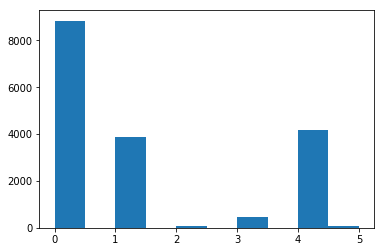

In [8]:
print("Distribution of samples by classes.")
plt.hist(Y_labels[:,1])
plt.show()

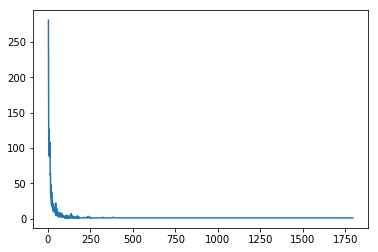

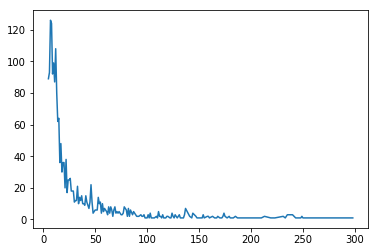

In [9]:
cutoff=2
xy_axis_if = list(Counter(lens_if).items())
xy_axis_labels = list(Counter(lens_labels).items())

xy_axis_if.sort(key=lambda x: x[0])
xy_axis_if=np.array(xy_axis_if)
xy_axis_if=xy_axis_if[np.where(xy_axis_if[:,0]>cutoff)]
x_axis_if, y_axis_if = zip(*xy_axis_if)
plt.plot(x_axis_if, y_axis_if)
plt.show()

xy_axis_labels.sort(key=lambda x: x[0])
xy_axis_labels=np.array(xy_axis_labels)
xy_axis_labels=xy_axis_if[np.where(xy_axis_labels[:,0]>cutoff)]
x_axis_labels, y_axis_labels = zip(*xy_axis_labels)
plt.plot(x_axis_labels, y_axis_labels)
plt.show()

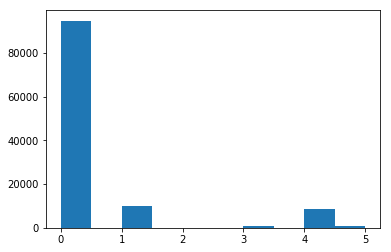

[(0, 67752), (1, 35777), (2, 9994), (3, 1520), (4, 108), (5, 16)]
47701


In [10]:
Y_train_flat  =[]
for y in Y_train:
    Y_train_flat += y
xy_axis_classes = Counter(np.array(Y_train_flat)[:,0])
#x_axis_classes,y_axis_classes = zip(*sorted(xy_axis_classes.items(),key=lambda x:x[0]))
#plt.plot(x_axis_classes,y_axis_classes)
plt.hist(np.array(Y_train_flat)[:,1])
plt.show()
print(sorted(xy_axis_classes.items(), key=lambda x:x[1], reverse=True))
len_methods=np.array(list(map(lambda x : len(x),X_train_long)))
print(max(len_methods))

In [11]:
lens = lens_labels
X_10 = np.where((lens<=10) )[0]
X_100 =  np.where(((lens>10) & (lens<=100)))[0]
X_1000 =  np.where((lens>100) & (lens<=1000))[0]
X_10000 = np.where((lens>1000) & (lens<=10000))[0]

In [12]:
print(len(X_10))
print(len(X_100))
print(len(X_1000))
print(len(X_10000))
sum([len(X_10),len(X_100),len(X_1000),len(X_10000)])

10857
6493
149
2


17501

In [13]:
indices=list(zip(range(len(lens_labels)),lens_labels))
indices=sorted(indices, key=lambda x:x[1])
indices, lens_sorted = zip(*indices)
indices = np.array(indices)[np.where(np.array(lens_sorted)>cutoff)]
lens_sorted = np.array(lens_sorted)

In [14]:
print(len(indices))
indices=indices[39:]
print(lens_labels[2])
Y_labels = np.array(Y_labels)

14690
18


In [15]:
X_labels=np.array(X_labels)

In [16]:
def length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
    length = tf.reduce_sum(used, 1)
    length = tf.cast(length, tf.int32)
    return length

def cost(output, target):
    # Compute cross entropy for each frame.
    cross_entropy = target * tf.log(output)
    cross_entropy = -tf.reduce_sum(cross_entropy, 2)
    mask = tf.sign(tf.reduce_max(tf.abs(target), 2))
    cross_entropy *= mask
    # Average over actual sequence lengths.
    cross_entropy = tf.reduce_sum(cross_entropy, 1)
    cross_entropy /= tf.reduce_sum(mask, 1)
    return tf.reduce_mean(cross_entropy)

def last_relevant(output, length):
    batch_size = tf.shape(output)[0]
    max_length = tf.shape(output)[1]
    out_size = int(output.get_shape()[2])
    index = tf.range(0, batch_size) * max_length + (length - 1)
    flat = tf.reshape(output, [-1, out_size])
    relevant = tf.gather(flat, index)
    return relevant


In [18]:
class RNN:
    
    def __init__(self, 
                 hidden_size = 300, 
                 batch_size = 16, 
                 learning_rate = 1e-1, 
                 output_size = None, 
                 num_features = None, 
                 num_epochs = 30, 
                 cell = tf.contrib.rnn.BasicLSTMCell,
                 activation = tf.nn.tanh,
                 num_layers = None,
                 dropout_rate = None,
                 bidirectional = False):
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        self.num_features = num_features
        self.num_epochs = num_epochs
        self.cell = cell
        self.activation = activation
        sefl.num_layers = num_layers
        
        self.n_steps = N//batch_size
        
        
        
        self.session = None
        self.graph = None
        
    def set_graph(self, graph):
        self.graph = graph
    
    def create_session(self):
        if self.grap:
            self.session = tf.session(graph=self.graph)
        else:
            self.session = tf.session()
    
    
        

In [19]:
'''keywords = ['_', 'if', 'else', 'while', 'for', 'switch']'''
output_size = np.max(Y_labels[:,1])+1
learning_rate = 1e-1
batch_size = 50
hidden_size = 300
'''
num_features depends how do u we want to represent data
we can use w2v embbeding to send dense represetation
#num_features =embeddings.shape[1]
we can use sparse representation which for this example requires over 5000 long one hot vector
we can use sparse representation taking only instruction without arguments lowering one hot to 203 dim

in this simple model dense representation didnt show better result then filtered representation 
with only instructions
'''

num_features = len(ByteCode.mnemonicMap)
num_epochs = 100

N = indices.shape[0]
n_steps = N//batch_size

In [22]:
rnn_graph = tf.Graph()

with rnn_graph.as_default():
    sequence = tf.placeholder(tf.float32,[batch_size, None ,num_features])
    labels= tf.placeholder(tf.float32,[batch_size,output_size])
    seq_len = tf.placeholder(tf.int32, [batch_size])

    #cell = tf.contrib.rnn.BasicLSTMCell(hidden_size)
    cell= tf.contrib.rnn.MultiRNNCell([
        tf.contrib.rnn.BasicLSTMCell(hidden_size,activation=tf.nn.tanh)
        for _ in range(4)])
    W_1 = tf.Variable(tf.random_normal([hidden_size, hidden_size]))
    b_1 = tf.Variable(tf.random_normal([hidden_size]))
    W_2 = tf.Variable(tf.random_normal([hidden_size, output_size]))
    b_2 = tf.Variable(tf.random_normal([output_size]))

    initial_state = cell.zero_state(batch_size, dtype=tf.float32)


    outputs, state = tf.nn.dynamic_rnn(cell, sequence, 
            initial_state=initial_state, sequence_length=seq_len)

    batch_len_t = tf.shape(outputs)[0]
    max_length_t = tf.shape(outputs)[1]
    out_size_t = int(outputs.get_shape()[2])
    index_t = tf.range(0, batch_len_t) * max_length_t + (seq_len - 1)
    flat_t = tf.reshape(outputs, [-1, out_size_t])
    output = tf.gather(flat_t, index_t)


    output_2 = tf.nn.relu(tf.matmul(output,W_1)+b_1)
    logits = tf.matmul(output_2, W_2)+b_2
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits)

    #train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    #changed to clip gradient
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gvs = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gvs]
    train_step = optimizer.apply_gradients(capped_gvs)
    
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    


E:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [30]:


with tf.Session(graph=rnn_graph) as session:
    iop = tf.global_variables_initializer()
    session.run(iop)
    for epoch in range(num_epochs):
        acc_sum=0
        loss_sum=0
        for step in range(n_steps):
            index = indices[batch_size*(step):batch_size*(step+1)]
            sequence_len = lens_labels[index]
            max_len = np.max(sequence_len)
            data = np.zeros([batch_size,max_len,num_features])
            batch_labels = np.eye(output_size)[Y_labels[index,1]]
            X = X_labels[index]
            for i in range(batch_size):
                for j in range(len([X[i]])):
                    if reverse_dictionary[X[i][j]] in ByteCode.mnemonicMap:
                        onehot = np.zeros(num_features)
                        onehot[ByteCode.mnemonicMap[reverse_dictionary[X[i][j]]].getByteCode()] = 1
                        data[i,j,:] = onehot#embeddings[X[i][j]]
            feed = {sequence:data,labels:batch_labels,seq_len:sequence_len}
            
            acc, pred, loss_val, _ = session.run([accuracy, correct_prediction,loss, train_step], feed_dict=feed)
            acc_sum += acc
            loss_sum += np.sum(loss_val)
            print(pred)
            print(batch_labels)
            
        print("acc:",acc_sum/n_steps)
        print("loss:", loss_sum/n_steps)
    

[ True  True  True  True  True False  True  True  True False False False
 False False False  True False False False  True  True  True False False
 False False False False False  True False False False False False False
 False  True  True  True  True  True  True False False  True False False
 False False]
[[ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  

KeyboardInterrupt: 

In [29]:
label_dist = Counter()
for method_label in Y_train:
    statement_type = [lab for emb, lab in method_label]
    label_dist += Counter(statement_type)

print(label_dist)

print(Counter(Y_labels[:,1]))
print()

Counter({0: 94766, 1: 10097, 4: 8539, 5: 986, 3: 750, 2: 29})
Counter({0: 8836, 4: 4191, 1: 3859, 3: 441, 2: 89, 5: 85})


In [39]:
output_size = np.max(Y_labels[:,1])+1
learning_rate = 1e-1
batch_size = 50
hidden_size = 300
'''
num_features depends how do u we want to represent data
we can use w2v embbeding to send dense represetation
#num_features =embeddings.shape[1]
we can use sparse representation which for this example requires over 5000 long one hot vector
we can use sparse representation taking only instruction without arguments lowering one hot to 203 dim

in this simple model dense representation didnt show better result then filtered representation 
with only instructions
'''

#num_features = len(ByteCode.mnemonicMap)
num_features =embeddings.shape[1]
num_epochs = 20

sequence_length = 100

rnn2_graph = tf.Graph()

with rnn2_graph.as_default():
    
    sequence = tf.placeholder(tf.float64,[batch_size, sequence_length ,num_features])
    labels= tf.placeholder(tf.float64,[batch_size, sequence_length, output_size])
    seq_len = tf.placeholder(tf.int64, [batch_size])

    cells_fw = [
        tf.nn.rnn_cell.DropoutWrapper(
        tf.contrib.rnn.BasicLSTMCell(hidden_size,activation=tf.nn.tanh),
        output_keep_prob = 0.8)
        for _ in range(2)]
    
    cells_bw = [
        tf.nn.rnn_cell.DropoutWrapper(
        tf.contrib.rnn.BasicLSTMCell(hidden_size,activation=tf.nn.tanh),
        output_keep_prob = 0.8)
        for _ in range(2)]
    

    
    W = tf.Variable(tf.random_normal([1,hidden_size*2, output_size], dtype=tf.float64))
    b = tf.Variable(tf.random_normal([output_size],dtype=tf.float64))

    #initial_state = cell_fw.zero_state(batch_size, dtype=tf.float64)


    #outputs, state = tf.nn.dynamic_rnn(cell, sequence, 
    #        initial_state=initial_state, sequence_length=seq_len)

    
    outputs, states_fw, states_bw = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
        cells_fw = cells_fw,
        cells_bw=cells_bw,
        dtype = tf.float64,
        sequence_length = seq_len,
        inputs = sequence)
    
    outputs = tf.concat(outputs, 2)
    
    logits  = tf.matmul(outputs, tf.tile(W, [tf.shape(outputs)[0],1,1]))
    logits = logits + tf.multiply(tf.ceil(logits),b)
    '''
    for output_batch, label_batch in zip(tf.unstack(outputs, axis=1), tf.unstack(labels, axis=1)):
        for output, label in zip(tf.unstack(output_batch, axis=0), tf.unstack(label_batch, axis=0)):
            output = tf.expand_dims(output, 0)
            label = tf.expand_dims(label, 0)
            logits = tf.matmul(output, W)+ b
            loss += tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logits)
            correct_predictions += tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float64))
        #incorrect_prediciton += batch_size - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)),tf.float64))
    '''
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits = logits)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    #accuracy = correct_predictions/tf.reduce_sum(tf.cast(seq_len,tf.float64))
    #acc_val, acc_op = tf.metrics.accuracy(tf.argmax(labels,axis=2), tf.argmax(logits, axis=2))
    diff = batch_size*sequence_length - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(labels, axis =2), tf.argmax(logits, axis=2)), tf.float32))
    nonpadsum = tf.cast(tf.reduce_sum(seq_len),tf.float32)
    accuracy = (nonpadsum- diff)/nonpadsum
    #correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  

In [40]:


N = X_train.shape[0]
n_steps = N//batch_size

with tf.Session(graph=rnn2_graph) as session:
    iop = tf.global_variables_initializer()
    loc = tf.local_variables_initializer()
    session.run(iop)
    #session.run(loc)
    for epoch in range(num_epochs):
        acc_sum=0
        for step in range(n_steps):
            batch = X_train[batch_size*step:batch_size*(step+1)]
            sequence_len = np.array(list(map(lambda x : len(x), batch)))
            max_len = np.max(sequence_len)
            if max_len>sequence_length or (len(batch)<batch_size):
                continue
            data = np.zeros([batch_size, sequence_length, num_features])
            filled_labels = np.zeros([batch_size, sequence_length, output_size])
            filled_labels[:,:,0] = 0
            for i, seq in enumerate(Y_train[batch_size*step:batch_size*(step+1)]):
                for j, label in enumerate(seq):
                    onehot=np.zeros(output_size)
                    onehot[label[1]] = 1
                    filled_labels[i,j,:] = onehot
                
            for i in range(batch_size):
                for j in range(len(batch[i])):
                    data[i,j,:] = embeddings[dictionary.get(batch[i][j],0)]
            
            feed = {sequence:data, labels:filled_labels, seq_len:sequence_len}
            
            logits_val, diff_val, acc_fixed, _= session.run([logits, diff, accuracy, train_step], feed_dict=feed)
            
            #acc_fixed = session.run([accuracy], feed_dict={seq_len:sequence_len})
            #session.run(loc)
            
            #print(acc_fixed)
            #print(diff_val)
            #print(np.sum(filled_labels))
            #print(np.sum(sequence_len))
            #print(np.argmax(filled_labels,axis=2)[0][:sequence_len[0]])
            #print(np.argmax(logits_val,axis=2)[0][:sequence_len[0]])
            '''
            zum = 0
            for i,sl in enumerate(sequence_len):
                zum += np.sum(np.argmax(logits_val[i,sl:,:],axis=1))
            print(zum)
            '''
            #print()
            acc_sum += acc_fixed
            
        print("Epoch %d, step %d ,acc: %f" % (epoch, step, acc_sum/n_steps))
        index = np.argmax(sequence_len)
        print(np.argmax(filled_labels,axis=2)[index][:sequence_len[index]])
        print(np.argmax(logits_val,axis=2)[index][:sequence_len[index]])

Epoch 0, step 109 ,acc: 0.699366
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 1, step 109 ,acc: 0.710177
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 2, step 109 ,acc: 0.716136
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 3, step 109 ,acc: 0.716284
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 

'''
2 CLASSES ONLY 
IF AND NOT-IF
'''

In [43]:
#output_size = np.max(Y_labels[:,1])+1
output_size = 2
learning_rate = 1e-2
batch_size = 16
hidden_size = 300
'''
num_features depends how do u we want to represent data
we can use w2v embbeding to send dense represetation
#num_features =embeddings.shape[1]
we can use sparse representation which for this example requires over 5000 long one hot vector
we can use sparse representation taking only instruction without arguments lowering one hot to 203 dim

in this simple model dense representation didnt show better result then filtered representation 
with only instructions
'''

#num_features = len(ByteCode.mnemonicMap)
num_features =embeddings.shape[1]
num_epochs = 30

sequence_length = 100

rnn2_graph = tf.Graph()

with rnn2_graph.as_default():
    
    sequence = tf.placeholder(tf.float64,[batch_size, sequence_length ,num_features])
    labels= tf.placeholder(tf.float64,[batch_size, sequence_length, output_size])
    seq_len = tf.placeholder(tf.int64, [batch_size])

    cells_fw = [
        tf.nn.rnn_cell.DropoutWrapper(
        tf.contrib.rnn.BasicLSTMCell(hidden_size,activation=tf.nn.tanh),
        output_keep_prob = 0.8)
        for _ in range(2)]
    
    cells_bw = [
        tf.nn.rnn_cell.DropoutWrapper(
        tf.contrib.rnn.BasicLSTMCell(hidden_size,activation=tf.nn.tanh),
        output_keep_prob = 0.8)
        for _ in range(2)]

    
    W = tf.Variable(tf.random_normal([1,hidden_size*2, output_size], dtype=tf.float64))
    b = tf.Variable(tf.random_normal([output_size],dtype=tf.float64))

    #initial_state = cell_fw.zero_state(batch_size, dtype=tf.float64)


    #outputs, state = tf.nn.dynamic_rnn(cell, sequence, 
    #        initial_state=initial_state, sequence_length=seq_len)

    
    outputs, states_fw, states_bw = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
        cells_fw = cells_fw,
        cells_bw=cells_bw,
        dtype = tf.float64,
        sequence_length = seq_len,
        inputs = sequence)
    
    outputs = tf.concat(outputs, 2)
    
    logits  = tf.matmul(outputs, tf.tile(W, [tf.shape(outputs)[0],1,1]))
    logits = logits + tf.multiply(tf.ceil(logits),b)
    '''
    for output_batch, label_batch in zip(tf.unstack(outputs, axis=1), tf.unstack(labels, axis=1)):
        for output, label in zip(tf.unstack(output_batch, axis=0), tf.unstack(label_batch, axis=0)):
            output = tf.expand_dims(output, 0)
            label = tf.expand_dims(label, 0)
            logits = tf.matmul(output, W)+ b
            loss += tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logits)
            correct_predictions += tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float64))
        #incorrect_prediciton += batch_size - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)),tf.float64))
    '''
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits = logits)

    optimizer = tf.train.AdamOptimizer(learning_rate)
    gvs = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
    train_step = optimizer.apply_gradients(capped_gvs)
    #accuracy = correct_predictions/tf.reduce_sum(tf.cast(seq_len,tf.float64))
    #acc_val, acc_op = tf.metrics.accuracy(tf.argmax(labels,axis=2), tf.argmax(logits, axis=2))
    diff = batch_size*sequence_length - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(labels, axis =2), tf.argmax(logits, axis=2)), tf.float32))
    nonpadsum = tf.cast(tf.reduce_sum(seq_len),tf.float32)
    accuracy = (nonpadsum- diff)/nonpadsum
    #correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  

In [45]:


N = X_train.shape[0]
n_steps = N//batch_size

with tf.Session(graph=rnn2_graph) as session:
    iop = tf.global_variables_initializer()
    loc = tf.local_variables_initializer()
    session.run(iop)
    #session.run(loc)
    for epoch in range(num_epochs):
        acc_sum=0
        for step in range(n_steps):
            batch = X_train[batch_size*step:batch_size*(step+1)]
            sequence_len = np.array(list(map(lambda x : len(x), batch)))
            max_len = np.max(sequence_len)
            if max_len>sequence_length or (len(batch)<batch_size):
                continue
            data = np.zeros([batch_size, sequence_length, num_features])
            filled_labels = np.zeros([batch_size, sequence_length, output_size])
            filled_labels[:,:,0] = 0
            for i, seq in enumerate(Y_train[batch_size*step:batch_size*(step+1)]):
                for j, label in enumerate(seq):
                    onehot=np.zeros(output_size)
                    index = int((label[1]==1) or (label[1]==2))
                    onehot[index] = 1
                    filled_labels[i,j,:] = onehot
                
            for i in range(batch_size):
                for j in range(len(batch[i])):
                    data[i,j,:] = embeddings[dictionary.get(batch[i][j],0)]
            
            feed = {sequence:data, labels:filled_labels, seq_len:sequence_len}
            
            logits_val, diff_val, acc_fixed, _= session.run([logits, diff, accuracy, train_step], feed_dict=feed)
            
            #acc_fixed = session.run([accuracy], feed_dict={seq_len:sequence_len})
            #session.run(loc)
            
            #print(acc_fixed)
            #print(diff_val)
            #print(np.sum(filled_labels))
            #print(np.sum(sequence_len))
            #print(np.argmax(filled_labels,axis=2)[0][:sequence_len[0]])
            #print(np.argmax(logits_val,axis=2)[0][:sequence_len[0]])
            '''
            zum = 0
            for i,sl in enumerate(sequence_len):
                zum += np.sum(np.argmax(logits_val[i,sl:,:],axis=1))
            print(zum)
            '''
            #print()
            acc_sum += acc_fixed
            
        print("Epoch %d, step %d ,acc: %f" % (epoch, step, acc_sum/n_steps))
        index = np.argmax(np.sum(np.argmax(filled_labels,axis=2),axis=1))
        print(np.argmax(filled_labels,axis=2)[index][:sequence_len[index]])
        print(np.argmax(logits_val,axis=2)[index][:sequence_len[index]])

Epoch 0, step 345 ,acc: 0.892036
[0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 1, step 345 ,acc: 0.916941
[0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 2, step 345 ,acc: 0.915420
[0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 3, step 345 ,acc: 0.918182
[0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 4, ste

KeyboardInterrupt: 

Training on data Only With If-s

In [47]:
X_only_if = []
Y_only_if = []
for x,y in zip(X_train, Y_train):
    y=np.array(y)
    if 1 in y[:,1]:
        X_only_if.append(x)
        Y_only_if.append(y)

X_only_if = np.array(X_only_if)
Y_only_if = np.array(Y_only_if)

In [48]:


N = X_only_if.shape[0]
n_steps = N//batch_size

with tf.Session(graph=rnn2_graph) as session:
    iop = tf.global_variables_initializer()
    loc = tf.local_variables_initializer()
    session.run(iop)
    #session.run(loc)
    for epoch in range(num_epochs):
        acc_sum=0
        for step in range(n_steps):
            batch = X_only_if[batch_size*step:batch_size*(step+1)]
            sequence_len = np.array(list(map(lambda x : len(x), batch)))
            max_len = np.max(sequence_len)
            if max_len>sequence_length or (len(batch)<batch_size):
                continue
            data = np.zeros([batch_size, sequence_length, num_features])
            filled_labels = np.zeros([batch_size, sequence_length, output_size])
            filled_labels[:,:,0] = 0
            for i, seq in enumerate(Y_only_if[batch_size*step:batch_size*(step+1)]):
                for j, label in enumerate(seq):
                    onehot=np.zeros(output_size)
                    index = int((label[1]==1) or (label[1]==2))
                    onehot[index] = 1
                    filled_labels[i,j,:] = onehot
                
            for i in range(batch_size):
                for j in range(len(batch[i])):
                    data[i,j,:] = embeddings[dictionary.get(batch[i][j],0)]
            
            feed = {sequence:data, labels:filled_labels, seq_len:sequence_len}
            
            logits_val, diff_val, acc_fixed, _= session.run([logits, diff, accuracy, train_step], feed_dict=feed)
            
            #acc_fixed = session.run([accuracy], feed_dict={seq_len:sequence_len})
            #session.run(loc)
            
            #print(acc_fixed)
            #print(diff_val)
            #print(np.sum(filled_labels))
            #print(np.sum(sequence_len))
            #print(np.argmax(filled_labels,axis=2)[0][:sequence_len[0]])
            #print(np.argmax(logits_val,axis=2)[0][:sequence_len[0]])
            '''
            zum = 0
            for i,sl in enumerate(sequence_len):
                zum += np.sum(np.argmax(logits_val[i,sl:,:],axis=1))
            print(zum)
            '''
            #print()
            acc_sum += acc_fixed
            
        print("Epoch %d, step %d ,acc: %f" % (epoch, step, acc_sum/n_steps))
        index = np.argmax(np.sum(np.argmax(filled_labels,axis=2),axis=1))
        print(np.argmax(filled_labels,axis=2)[index][:sequence_len[index]])
        print(np.argmax(logits_val,axis=2)[index][:sequence_len[index]])

Epoch 0, step 58 ,acc: 0.693291
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 1, step 58 ,acc: 0.789828
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 2, step 58 ,acc: 0.870239
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 3, step 58 ,acc: 0.902794
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Testing on whole dataset

In [49]:


N = X_train.shape[0]
n_steps = N//batch_size
num_epochs = 1

with tf.Session(graph=rnn2_graph) as session:
    iop = tf.global_variables_initializer()
    loc = tf.local_variables_initializer()
    session.run(iop)
    #session.run(loc)
    for epoch in range(num_epochs):
        acc_sum=0
        for step in range(n_steps):
            batch = X_train[batch_size*step:batch_size*(step+1)]
            sequence_len = np.array(list(map(lambda x : len(x), batch)))
            max_len = np.max(sequence_len)
            if max_len>sequence_length or (len(batch)<batch_size):
                continue
            data = np.zeros([batch_size, sequence_length, num_features])
            filled_labels = np.zeros([batch_size, sequence_length, output_size])
            filled_labels[:,:,0] = 0
            for i, seq in enumerate(Y_train[batch_size*step:batch_size*(step+1)]):
                for j, label in enumerate(seq):
                    onehot=np.zeros(output_size)
                    index = int((label[1]==1) or (label[1]==2))
                    onehot[index] = 1
                    filled_labels[i,j,:] = onehot
                
            for i in range(batch_size):
                for j in range(len(batch[i])):
                    data[i,j,:] = embeddings[dictionary.get(batch[i][j],0)]
            
            feed = {sequence:data, labels:filled_labels, seq_len:sequence_len}
            
            logits_val, diff_val, acc_fixed = session.run([logits, diff, accuracy], feed_dict=feed)
            
            #acc_fixed = session.run([accuracy], feed_dict={seq_len:sequence_len})
            #session.run(loc)
            
            print(acc_fixed)
            #print(diff_val)
            #print(np.sum(filled_labels))
            #print(np.sum(sequence_len))
            #print(np.argmax(filled_labels,axis=2)[0][:sequence_len[0]])
            #print(np.argmax(logits_val,axis=2)[0][:sequence_len[0]])
            '''
            zum = 0
            for i,sl in enumerate(sequence_len):
                zum += np.sum(np.argmax(logits_val[i,sl:,:],axis=1))
            print(zum)
            '''
            #print()
            acc_sum += acc_fixed
            
        print("Epoch %d, step %d ,acc: %f" % (epoch, step, acc_sum/n_steps))
        index = np.argmax(np.sum(np.argmax(Y_train,axis=2),axis=1))
        print(np.argmax(filled_labels,axis=2)[index][:sequence_len[index]])
        print(np.argmax(logits_val,axis=2)[index][:sequence_len[index]])

0.561772
0.581053
0.714689
0.582938
0.729258
0.676596
0.609665
0.675573
0.799087
0.666667
0.67094
0.630542
0.710456
0.643172
0.549521
0.63913
0.740909
0.67033
0.676647
0.476281
0.653979
0.649733
0.482955
0.641379
0.735294
0.598326
0.509901
0.710227
0.596244
0.538058
0.694704
0.608579
0.615385
0.65587
0.706122
0.505415
0.671569
0.579399
0.781457
0.60105
0.504505
0.711775
0.75638
0.676923
0.661238
0.455814
0.826087
0.610329
0.603093
0.716667
0.823529
0.826087
0.661157
0.668367
0.589286
0.469565
0.634538
0.688525
0.691892
0.621053
0.595908
0.798403
0.640127
0.637295
0.571429
0.70073
0.707965
0.683486
0.625749
0.685589
0.641304
0.649275
0.666667
0.790657
0.75
0.751553
0.5
0.60828
0.586563
0.473684
0.658249
0.574879
0.703226
0.622419
0.677665
0.580729
0.586207
0.751269
0.803235
0.698758
0.58209
0.610592
0.458661
0.445652
0.642857
0.894472
0.575829
0.669187
0.647706
0.628378
0.569975
0.623693
0.613027
0.77827
0.734104
0.550802
0.604563
0.715151
0.582589
0.52579
0.54102
0.672269
0.763158
0.82

AxisError: axis 2 is out of bounds for array of dimension 1

Without embeddings

In [54]:
#output_size = np.max(Y_labels[:,1])+1
output_size = 2
learning_rate = 1e-2
batch_size = 16
hidden_size = 300
'''
num_features depends how do u we want to represent data
we can use w2v embbeding to send dense represetation
#num_features =embeddings.shape[1]
we can use sparse representation which for this example requires over 5000 long one hot vector
we can use sparse representation taking only instruction without arguments lowering one hot to 203 dim

in this simple model dense representation didnt show better result then filtered representation 
with only instructions
'''

#num_features = len(ByteCode.mnemonicMap)
num_features = embeddings.shape[0]
num_epochs = 30

sequence_length = 100

rnn2_graph = tf.Graph()

with rnn2_graph.as_default():
    
    sequence = tf.placeholder(tf.float64,[batch_size, sequence_length ,num_features])
    labels= tf.placeholder(tf.float64,[batch_size, sequence_length, output_size])
    seq_len = tf.placeholder(tf.int64, [batch_size])

    cells_fw = [
        tf.nn.rnn_cell.DropoutWrapper(
        tf.contrib.rnn.BasicLSTMCell(hidden_size,activation=tf.nn.tanh),
        output_keep_prob = 0.8)
        for _ in range(2)]
    
    cells_bw = [
        tf.nn.rnn_cell.DropoutWrapper(
        tf.contrib.rnn.BasicLSTMCell(hidden_size,activation=tf.nn.tanh),
        output_keep_prob = 0.8)
        for _ in range(2)]

    
    W = tf.Variable(tf.random_normal([1,hidden_size*2, output_size], dtype=tf.float64))
    b = tf.Variable(tf.random_normal([output_size],dtype=tf.float64))

    #initial_state = cell_fw.zero_state(batch_size, dtype=tf.float64)


    #outputs, state = tf.nn.dynamic_rnn(cell, sequence, 
    #        initial_state=initial_state, sequence_length=seq_len)

    
    outputs, states_fw, states_bw = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
        cells_fw = cells_fw,
        cells_bw=cells_bw,
        dtype = tf.float64,
        sequence_length = seq_len,
        inputs = sequence)
    
    outputs = tf.concat(outputs, 2)
    
    logits  = tf.matmul(outputs, tf.tile(W, [tf.shape(outputs)[0],1,1]))
    logits = logits + tf.multiply(tf.ceil(logits),b)
    '''
    for output_batch, label_batch in zip(tf.unstack(outputs, axis=1), tf.unstack(labels, axis=1)):
        for output, label in zip(tf.unstack(output_batch, axis=0), tf.unstack(label_batch, axis=0)):
            output = tf.expand_dims(output, 0)
            label = tf.expand_dims(label, 0)
            logits = tf.matmul(output, W)+ b
            loss += tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logits)
            correct_predictions += tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float64))
        #incorrect_prediciton += batch_size - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)),tf.float64))
    '''
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits = logits)

    optimizer = tf.train.AdamOptimizer(learning_rate)
    gvs = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
    train_step = optimizer.apply_gradients(capped_gvs)
    #accuracy = correct_predictions/tf.reduce_sum(tf.cast(seq_len,tf.float64))
    #acc_val, acc_op = tf.metrics.accuracy(tf.argmax(labels,axis=2), tf.argmax(logits, axis=2))
    diff = batch_size*sequence_length - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(labels, axis =2), tf.argmax(logits, axis=2)), tf.float32))
    nonpadsum = tf.cast(tf.reduce_sum(seq_len),tf.float32)
    accuracy = (nonpadsum- diff)/nonpadsum
    #correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  

In [55]:


N = X_only_if.shape[0]
n_steps = N//batch_size

with tf.Session(graph=rnn2_graph) as session:
    iop = tf.global_variables_initializer()
    loc = tf.local_variables_initializer()
    session.run(iop)
    #session.run(loc)
    for epoch in range(num_epochs):
        acc_sum=0
        for step in range(n_steps):
            batch = X_only_if[batch_size*step:batch_size*(step+1)]
            sequence_len = np.array(list(map(lambda x : len(x), batch)))
            max_len = np.max(sequence_len)
            if max_len>sequence_length or (len(batch)<batch_size):
                continue
            data = np.zeros([batch_size, sequence_length, num_features])
            filled_labels = np.zeros([batch_size, sequence_length, output_size])
            filled_labels[:,:,0] = 0
            for i, seq in enumerate(Y_only_if[batch_size*step:batch_size*(step+1)]):
                for j, label in enumerate(seq):
                    onehot=np.zeros(output_size)
                    index = int((label[1]==1) or (label[1]==2))
                    onehot[index] = 1
                    filled_labels[i,j,:] = onehot
                
            for i in range(batch_size):
                for j in range(len(batch[i])):
                    onehot = np.zeros(num_features)
                    onehot[dictionary.get(batch[i][j],0)] = 1
                    data[i,j,:] = onehot
            
            feed = {sequence:data, labels:filled_labels, seq_len:sequence_len}
            
            logits_val, diff_val, acc_fixed, _= session.run([logits, diff, accuracy, train_step], feed_dict=feed)
            
            #acc_fixed = session.run([accuracy], feed_dict={seq_len:sequence_len})
            #session.run(loc)
            
            #print(acc_fixed)
            #print(diff_val)
            #print(np.sum(filled_labels))
            #print(np.sum(sequence_len))
            #print(np.argmax(filled_labels,axis=2)[0][:sequence_len[0]])
            #print(np.argmax(logits_val,axis=2)[0][:sequence_len[0]])
            '''
            zum = 0
            for i,sl in enumerate(sequence_len):
                zum += np.sum(np.argmax(logits_val[i,sl:,:],axis=1))
            print(zum)
            '''
            #print()
            acc_sum += acc_fixed
            
        print("Epoch %d, step %d ,acc: %f" % (epoch, step, acc_sum/n_steps))
        index = np.argmax(np.sum(np.argmax(filled_labels,axis=2),axis=1))
        print(np.argmax(filled_labels,axis=2)[index][:sequence_len[index]])
        print(np.argmax(logits_val,axis=2)[index][:sequence_len[index]])

Epoch 0, step 58 ,acc: 0.733803
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1
 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
Epoch 1, step 58 ,acc: 0.881594
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 2, step 58 ,acc: 0.935523
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 3, step 58 ,acc: 0.944760
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

KeyboardInterrupt: 

Removing data with only zero class

In [31]:
X_only_nonzero = []
Y_only_nonzero = []
for x,y in zip(X_train, Y_train):
    y=np.array(y)
    if np.sum(y[:,1])>0:
        X_only_nonzero.append(x)
        Y_only_nonzero.append(y)

X_only_nonzero = np.array(X_only_nonzero)
Y_only_nonzero = np.array(Y_only_nonzero)

In [76]:
output_size = np.max(Y_labels[:,1])+1
learning_rate = 1e-1
batch_size = 50
hidden_size = 300
'''
num_features depends how do u we want to represent data
we can use w2v embbeding to send dense represetation
#num_features =embeddings.shape[1]
we can use sparse representation which for this example requires over 5000 long one hot vector
we can use sparse representation taking only instruction without arguments lowering one hot to 203 dim

in this simple model dense representation didnt show better result then filtered representation 
with only instructions
'''

#num_features = len(ByteCode.mnemonicMap)
num_features =embeddings.shape[1]
num_epochs = 50

sequence_length = 100

rnn2_graph = tf.Graph()

with rnn2_graph.as_default():
    
    sequence = tf.placeholder(tf.float32,[batch_size, sequence_length ,num_features])
    labels= tf.placeholder(tf.float32,[batch_size, sequence_length, output_size])
    seq_len = tf.placeholder(tf.int32, [batch_size])

    cells_fw = [
        tf.nn.rnn_cell.DropoutWrapper(
        tf.contrib.rnn.BasicRNNCell(hidden_size),
        output_keep_prob = 0.8)
        for _ in range(2)]
    
    cells_bw = [
        tf.nn.rnn_cell.DropoutWrapper(
        tf.contrib.rnn.BasicRNNCell(hidden_size),
        output_keep_prob = 0.8)
        for _ in range(2)]
    

    
    W = tf.Variable(tf.random_normal([1,hidden_size*2, output_size], dtype=tf.float32))
    b = tf.Variable(tf.random_normal([output_size],dtype=tf.float32))

    #initial_state = cell_fw.zero_state(batch_size, dtype=tf.float64)


    #outputs, state = tf.nn.dynamic_rnn(cell, sequence, 
    #        initial_state=initial_state, sequence_length=seq_len)

    
    outputs, states_fw, states_bw = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
        cells_fw = cells_fw,
        cells_bw=cells_bw,
        dtype = tf.float32,
        sequence_length = seq_len,
        inputs = sequence)
    
    outputs = tf.concat(outputs, 2)
    
    logits  = tf.matmul(outputs, tf.tile(W, [tf.shape(outputs)[0],1,1]))
    logits = logits + tf.multiply(tf.ceil(logits),b)
    '''
    for output_batch, label_batch in zip(tf.unstack(outputs, axis=1), tf.unstack(labels, axis=1)):
        for output, label in zip(tf.unstack(output_batch, axis=0), tf.unstack(label_batch, axis=0)):
            output = tf.expand_dims(output, 0)
            label = tf.expand_dims(label, 0)
            logits = tf.matmul(output, W)+ b
            loss += tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logits)
            correct_predictions += tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float64))
        #incorrect_prediciton += batch_size - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)),tf.float64))
    '''
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits = logits)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    #accuracy = correct_predictions/tf.reduce_sum(tf.cast(seq_len,tf.float64))
    #acc_val, acc_op = tf.metrics.accuracy(tf.argmax(labels,axis=2), tf.argmax(logits, axis=2))
    diff = batch_size*sequence_length - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(labels, axis =2), tf.argmax(logits, axis=2)), tf.float32))
    nonpadsum = tf.cast(tf.reduce_sum(seq_len),tf.float32)
    accuracy = (nonpadsum- diff)/nonpadsum
    #correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

In [77]:

X_run = X_only_nonzero
Y_run = Y_only_nonzero

N = X_run.shape[0]
n_steps = N//batch_size

with tf.Session(graph=rnn2_graph) as session:
    iop = tf.global_variables_initializer()
    loc = tf.local_variables_initializer()
    session.run(iop)
    #session.run(loc)
    for epoch in range(num_epochs):
        acc_sum=0
        for step in range(n_steps):
            batch = X_run[batch_size*step:batch_size*(step+1)]
            sequence_len = np.array(list(map(lambda x : len(x), batch)))
            max_len = np.max(sequence_len)
            if max_len>sequence_length or (len(batch)<batch_size):
                continue
            data = np.zeros([batch_size, sequence_length, num_features])
            filled_labels = np.zeros([batch_size, sequence_length, output_size])
            filled_labels[:,:,0] = 0
            for i, seq in enumerate(Y_run[batch_size*step:batch_size*(step+1)]):
                for j, label in enumerate(seq):
                    onehot=np.zeros(output_size)
                    onehot[label[1]] = 1
                    filled_labels[i,j,:] = onehot
                
            for i in range(batch_size):
                for j in range(len(batch[i])):
                    data[i,j,:] = embeddings[dictionary.get(batch[i][j],0)]
            
            feed = {sequence:data, labels:filled_labels, seq_len:sequence_len}
            
            logits_val, diff_val, acc_fixed, _= session.run([logits, diff, accuracy, train_step], feed_dict=feed)
            
            #acc_fixed = session.run([accuracy], feed_dict={seq_len:sequence_len})
            #session.run(loc)
            
            #print(acc_fixed)
            #print(diff_val)
            #print(np.sum(filled_labels))
            #print(np.sum(sequence_len))
            #print(np.argmax(filled_labels,axis=2)[0][:sequence_len[0]])
            #print(np.argmax(logits_val,axis=2)[0][:sequence_len[0]])
            '''
            zum = 0
            for i,sl in enumerate(sequence_len):
                zum += np.sum(np.argmax(logits_val[i,sl:,:],axis=1))
            print(zum)
            '''
            #print()
            acc_sum += acc_fixed
            
        print("Epoch %d, step %d ,acc: %f" % (epoch, step, acc_sum/n_steps))
        index = np.argmax(sequence_len)
        print(np.argmax(filled_labels,axis=2)[index][:sequence_len[index]])
        print(np.argmax(logits_val,axis=2)[index][:sequence_len[index]])

Epoch 0, step 25 ,acc: 0.199527
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 4 4 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0]
[1 0 5 5 1 5 5 5 1 1 5 0 1 5 5 2 4 5 0 0 5 5 5 0 5 1 5 2 4 5 0 5 1 1 0 0 1
 5 0 5 1 1 5 5 1 1 0 5 1 1 5 5 1 0 0 0 1 5 0 2 5 5 5 0 5 5 5 0 1 1 0 5 5 5
 0 0 1 1 0 5 4 5 5 5 1 1 0 5 1 1 5 5 1 5 0 5 1 5 0]
Epoch 1, step 25 ,acc: 0.152327
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 4 4 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0]
[1 1 3 5 5 1 3 3 1 1 3 3 1 1 5 3 1 1 3 3 5 5 3 3 5 5 2 3 5 5 5 2 1 5 3 5 5
 1 3 3 5 5 2 3 1 5 2 2 5 5 3 2 1 5 3 3 5 1 5 3 5 1 0 2 5 5 3 5 5 5 2 3 5 5
 5 3 1 5 3 2 1 5 0 3 1 0 3 3 5 5 3 3 5 5 5 2 1 1 3]
Epoch 2, step 25 ,acc: 0.169131
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 0 

TypeError: 'Tensor' object is not iterable.

In [84]:
output_size = np.max(Y_labels[:,1])+1
learning_rate = 1e-1
batch_size = 50
hidden_size = 300
'''
num_features depends how do u we want to represent data
we can use w2v embbeding to send dense represetation
#num_features =embeddings.shape[1]
we can use sparse representation which for this example requires over 5000 long one hot vector
we can use sparse representation taking only instruction without arguments lowering one hot to 203 dim

in this simple model dense representation didnt show better result then filtered representation 
with only instructions
'''

#num_features = len(ByteCode.mnemonicMap)
num_features =embeddings.shape[1]
num_epochs = 100

sequence_length = 100

rnn2_graph = tf.Graph()

with rnn2_graph.as_default():
    
    sequence = tf.placeholder(tf.float32,[batch_size, sequence_length ,num_features])
    labels= tf.placeholder(tf.float32,[batch_size, sequence_length, output_size])
    seq_len = tf.placeholder(tf.int32, [batch_size])
    mask = tf.placeholder(tf.float32, [batch_size, sequence_length, output_size])

    cells_fw = [
        tf.nn.rnn_cell.DropoutWrapper(
        tf.contrib.rnn.BasicLSTMCell(hidden_size),
        output_keep_prob = 0.8)
        for _ in range(2)]
    
    cells_bw = [
        tf.nn.rnn_cell.DropoutWrapper(
        tf.contrib.rnn.BasicLSTMCell(hidden_size),
        output_keep_prob = 0.8)
        for _ in range(2)]
    

    
    W = tf.Variable(tf.random_normal([1,hidden_size*2, output_size], dtype=tf.float32))
    b = tf.Variable(tf.random_normal([output_size],dtype=tf.float32))

    #initial_state = cell_fw.zero_state(batch_size, dtype=tf.float64)


    #outputs, state = tf.nn.dynamic_rnn(cell, sequence, 
    #        initial_state=initial_state, sequence_length=seq_len)

    
    outputs, states_fw, states_bw = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
        cells_fw = cells_fw,
        cells_bw=cells_bw,
        dtype = tf.float32,
        sequence_length = seq_len,
        inputs = sequence)
    
    outputs = tf.concat(outputs, 2)
    
    #logits  = tf.matmul(outputs, tf.tile(W, [tf.shape(outputs)[0],1,1]))
    #logits = logits + tf.multiply(tf.ceil(logits),b)
    logits = tf.matmul(outputs, tf.tile(W, [tf.shape(outputs)[0],1,1])) + b
    logits = logits*mask
    '''
    for output_batch, label_batch in zip(tf.unstack(outputs, axis=1), tf.unstack(labels, axis=1)):
        for output, label in zip(tf.unstack(output_batch, axis=0), tf.unstack(label_batch, axis=0)):
            output = tf.expand_dims(output, 0)
            label = tf.expand_dims(label, 0)
            logits = tf.matmul(output, W)+ b
            loss += tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logits)
            correct_predictions += tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float64))
        #incorrect_prediciton += batch_size - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)),tf.float64))
    '''
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits = logits)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    #accuracy = correct_predictions/tf.reduce_sum(tf.cast(seq_len,tf.float64))
    #acc_val, acc_op = tf.metrics.accuracy(tf.argmax(labels,axis=2), tf.argmax(logits, axis=2))
    diff = batch_size*sequence_length - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(labels, axis =2), tf.argmax(logits, axis=2)), tf.float32))
    nonpadsum = tf.cast(tf.reduce_sum(seq_len),tf.float32)
    accuracy = (nonpadsum- diff)/nonpadsum
    #correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

In [85]:

X_run = X_only_nonzero
Y_run = Y_only_nonzero

N = X_run.shape[0]
n_steps = N//batch_size

with tf.Session(graph=rnn2_graph) as session:
    iop = tf.global_variables_initializer()
    loc = tf.local_variables_initializer()
    session.run(iop)
    #session.run(loc)
    for epoch in range(num_epochs):
        acc_sum=0
        for step in range(n_steps):
            batch = X_run[batch_size*step:batch_size*(step+1)]
            sequence_len = np.array(list(map(lambda x : len(x), batch)))
            max_len = np.max(sequence_len)
            if max_len>sequence_length or (len(batch)<batch_size):
                continue
            data = np.zeros([batch_size, sequence_length, num_features])
            filled_labels = np.zeros([batch_size, sequence_length, output_size])
            filled_labels[:,:,0] = 0
            mask_val = np.zeros([batch_size, sequence_length, output_size])
            for i, seq in enumerate(Y_run[batch_size*step:batch_size*(step+1)]):
                for j, label in enumerate(seq):
                    onehot=np.zeros(output_size)
                    onehot[label[1]] = 1
                    filled_labels[i,j,:] = onehot
                    mask_val[i,j,:] = 1
                
            for i in range(batch_size):
                for j in range(len(batch[i])):
                    data[i,j,:] = embeddings[dictionary.get(batch[i][j],0)]
            
            feed = {sequence:data, labels:filled_labels, seq_len:sequence_len, mask:mask_val}
            
            logits_val, diff_val, acc_fixed, _= session.run([logits, diff, accuracy, train_step], feed_dict=feed)
            
            #acc_fixed = session.run([accuracy], feed_dict={seq_len:sequence_len})
            #session.run(loc)
            
            #print(acc_fixed)
            #print(diff_val)
            #print(np.sum(filled_labels))
            #print(np.sum(sequence_len))
            #print(np.argmax(filled_labels,axis=2)[0][:sequence_len[0]])
            #print(np.argmax(logits_val,axis=2)[0][:sequence_len[0]])
            '''
            zum = 0
            for i,sl in enumerate(sequence_len):
                zum += np.sum(np.argmax(logits_val[i,sl:,:],axis=1))
            print(zum)
            '''
            #print()
            acc_sum += acc_fixed
            
        print("Epoch %d, step %d ,acc: %f" % (epoch, step, acc_sum/n_steps))
        index = np.argmax(sequence_len)
        print(np.argmax(filled_labels,axis=2)[index][:sequence_len[index]])
        print(np.argmax(logits_val,axis=2)[index][:sequence_len[index]])

Epoch 0, step 25 ,acc: 0.512623
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 4 4 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0]
[1 1 1 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 4 0 0 0 0 0 0 0 4 0 4 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0]
Epoch 1, step 25 ,acc: 0.540918
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 4 4 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 3 4 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 2, step 25 ,acc: 0.547801
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 0 

In [32]:
num_bits = 16
zero_value = 2**(num_bits-1)
def gray_code(n):
    n -= 1
    return format(n^(n >> 1), '0'+str(num_bits)+'b')

def bin_code(n):
    return format(n, '0'+str(num_bits)+'b')

def encode_arg(value):
    n=zero_value+value
    return np.array(list(map(lambda x: int(x), list(bin_code(n)))))

In [33]:
num_instructions = len(ByteCode.mnemonicMap)
encoding_len = num_instructions + num_bits
encode_dict = dict( zip(ByteCode.mnemonicMap.keys(),range(num_instructions)) )

X_encoded = []
Y_encoded = []

for x_seq,y_seq in zip(X_train,Y_train):
    encoded_x_seq = []
    encoded_y_seq = []
    if not any(substring in string for substring in ['if', 'goto'] for string in x_seq):
        continue
    for x,y in zip(x_seq, y_seq):
        x_vector = np.zeros(encoding_len)
        if x in encode_dict:
            onehot = np.zeros(num_instructions)
            onehot[encode_dict[x]] = 1
            x_vector[:num_instructions] = onehot
        else:
            try:
                value=int(x)
                x_vector[num_instructions:] = encode_arg(value)
            except ValueError as e:
                continue
        encoded_x_seq.append(x_vector)
        encoded_y_seq.append(y)
    X_encoded.append(encoded_x_seq)
    Y_encoded.append(encoded_y_seq)

In [42]:
#output_size = np.max(Y_labels[:,1])+1
output_size = 3
learning_rate = 1e-1
batch_size = 50
hidden_size = 300
'''
num_features depends how do u we want to represent data
we can use w2v embbeding to send dense represetation
#num_features =embeddings.shape[1]
we can use sparse representation which for this example requires over 5000 long one hot vector
we can use sparse representation taking only instruction without arguments lowering one hot to 203 dim

in this simple model dense representation didnt show better result then filtered representation 
with only instructions
'''

#num_features = len(ByteCode.mnemonicMap)
#num_features =embeddings.shape[1]
num_features = encoding_len
num_epochs = 100

sequence_length = 50

rnn2_graph = tf.Graph()

with rnn2_graph.as_default():
    
    sequence = tf.placeholder(tf.float32,[batch_size, sequence_length ,num_features])
    labels= tf.placeholder(tf.float32,[batch_size, sequence_length, output_size])
    seq_len = tf.placeholder(tf.int32, [batch_size])
    mask = tf.placeholder(tf.float32, [batch_size, sequence_length, output_size])

    cells_fw = [
        tf.contrib.rnn.BasicLSTMCell(hidden_size)
        for _ in range(1)]
    
    cells_bw = [
        tf.contrib.rnn.BasicLSTMCell(hidden_size)
        for _ in range(1)]
    

    
    W_1 = tf.Variable(tf.random_normal([1,hidden_size*2, hidden_size*2]))
    b_1 = tf.Variable(tf.random_normal([hidden_size*2]))
    W_2 = tf.Variable(tf.random_normal([1,hidden_size*2, output_size]))
    b_2 = tf.Variable(tf.random_normal([output_size]))

    #initial_state = cell_fw.zero_state(batch_size, dtype=tf.float64)


    #outputs, state = tf.nn.dynamic_rnn(cell, sequence, 
    #        initial_state=initial_state, sequence_length=seq_len)

    
    outputs, states_fw, states_bw = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
        cells_fw = cells_fw,
        cells_bw=cells_bw,
        dtype = tf.float32,
        sequence_length = seq_len,
        inputs = sequence)
    
    outputs = tf.concat(outputs, 2)
    
    #logits  = tf.matmul(outputs, tf.tile(W, [tf.shape(outputs)[0],1,1]))
    #logits = logits + tf.multiply(tf.ceil(logits),b)
    outputs_2 = tf.nn.relu(tf.matmul(outputs, tf.tile(W_1, [tf.shape(outputs)[0],1,1])) + b_1)
    logits = tf.matmul(outputs_2, tf.tile(W_2, [tf.shape(outputs_2)[0],1,1])+b_2)
    logits = logits*mask
    '''
    for output_batch, label_batch in zip(tf.unstack(outputs, axis=1), tf.unstack(labels, axis=1)):
        for output, label in zip(tf.unstack(output_batch, axis=0), tf.unstack(label_batch, axis=0)):
            output = tf.expand_dims(output, 0)
            label = tf.expand_dims(label, 0)
            logits = tf.matmul(output, W)+ b
            loss += tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logits)
            correct_predictions += tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float64))
        #incorrect_prediciton += batch_size - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)),tf.float64))
    '''
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits = logits)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    #accuracy = correct_predictions/tf.reduce_sum(tf.cast(seq_len,tf.float64))
    #acc_val, acc_op = tf.metrics.accuracy(tf.argmax(labels,axis=2), tf.argmax(logits, axis=2))
    diff = batch_size*sequence_length - tf.reduce_sum(tf.cast(tf.equal(tf.argmax(labels, axis =2), tf.argmax(logits, axis=2)), tf.float32))
    nonpadsum = tf.cast(tf.reduce_sum(seq_len),tf.float32)
    accuracy = (nonpadsum- diff)/nonpadsum
    #correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

In [43]:

X_run = X_encoded
Y_run = Y_encoded

baseline_acc = 0
num_label = 0
for y_seq in Y_run:
    y_seq = np.array(y_seq)
    baseline_acc += np.sum((y_seq[:,1] == 0))
    baseline_acc += np.sum(y_seq[:,1] == 3)
    baseline_acc += np.sum(y_seq[:,1] == 4)
    baseline_acc += np.sum(y_seq[:,1] == 5)
    num_label += len(y_seq)
baseline_acc /= num_label

print('BASELINE ACC:', baseline_acc)

from random import randrange


N = len(X_run)
n_steps = N//batch_size

with tf.Session(graph=rnn2_graph) as session:
    iop = tf.global_variables_initializer()
    loc = tf.local_variables_initializer()
    session.run(iop)
    #session.run(loc)
    for epoch in range(num_epochs):
        acc_sum=0
        batch_index = 0
        for step in range(n_steps):
            #batch = X_run[batch_size*step:batch_size*(step+1)]
            cur_size = 0
            batch = []
            batch_Y = []
            while(cur_size<batch_size):
                if batch_index == len(X_run):
                    batch_index = 0
                if len(X_run[batch_index])<= sequence_length:
                    batch.append(X_run[batch_index])
                    batch_Y.append(Y_run[batch_index])
                    cur_size += 1
                batch_index += 1
            sequence_len = np.array(list(map(lambda x : len(x), batch)))
            max_len = np.max(sequence_len)
            if max_len>sequence_length or (len(batch)<batch_size):
                continue
            data = np.zeros([batch_size, sequence_length, num_features])
            filled_labels = np.zeros([batch_size, sequence_length, output_size])
            filled_labels[:,:,0] = 0
            mask_val = np.zeros([batch_size, sequence_length, output_size])
            for i, seq in enumerate(batch_Y):
                for j, label in enumerate(seq):
                    index = 0
                    if label[1]==1 or label[1]==2:
                        index = label[1]
                    onehot=np.zeros(output_size)
                    onehot[index] = 1
                    filled_labels[i,j,:] = onehot
                    mask_val[i,j,:] = 1
                
            for i in range(batch_size):
                for j in range(len(batch[i])):
                    data[i,j,:] = batch[i][j]
            
            feed = {sequence:data, labels:filled_labels, seq_len:sequence_len, mask:mask_val}
            
            logits_val, diff_val, acc_fixed, _= session.run([logits, diff, accuracy, train_step], feed_dict=feed)
            
            #acc_fixed = session.run([accuracy], feed_dict={seq_len:sequence_len})
            #session.run(loc)
            
            #print(acc_fixed)
            #print(diff_val)
            #print(np.sum(filled_labels))
            #print(np.sum(sequence_len))
            #print(np.argmax(filled_labels,axis=2)[0][:sequence_len[0]])
            #print(np.argmax(logits_val,axis=2)[0][:sequence_len[0]])
            '''
            zum = 0
            for i,sl in enumerate(sequence_len):
                zum += np.sum(np.argmax(logits_val[i,sl:,:],axis=1))
            print(zum)
            '''
            #print()
            acc_sum += acc_fixed
            
        print("Epoch %d, step %d ,acc: %f" % (epoch, step, acc_sum/n_steps))
        index = np.argmax(sequence_len)#np.argmax(sequence_len)
        print(np.argmax(filled_labels,axis=2)[index][:sequence_len[index]])
        print(np.argmax(logits_val,axis=2)[index][:sequence_len[index]])

BASELINE ACC: 0.856644186125
Epoch 0, step 38 ,acc: 0.733744
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 1, step 38 ,acc: 0.788401
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 1 1 0 0 1 1 1 0 0 0 0 0]
Epoch 2, step 38 ,acc: 0.840512
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 3, step 38 ,acc: 0.861482
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Epoch 4, step 38 ,a